# K-Means Clustering applied to Sporulation Dataset

## Introduction

This Jupyter Notebook contains all the code used to replicate the results from the paper [Comparisons and validation of statistical clustering techniques for microarray gene expression data](../docs/papers/A1-Comparison-Bioinformatics-2003-Datta.pdf), in particular, the application of *K-Means clustering* to the *Sporulation Dataset*, which contains data from the output of DNA microarrays, which captured the expression levels of nearly every yeast gene during sporulation, first published in the paper [Transcriptional Program of Sportulation in Budding Yeast](../docs/papers/A2-The%20Transcriptional%20Program%20of%20Sporulation%20in%20Budding%20Yeast.pdf).

In [30]:
# Import libraries
from typing import List, Dict # Typing for functions

import pandas as pd # DataFrame manipulation
import numpy as np # Vectorized operations for large data
import ast # Helps Python to process trees o the Python abstract syntax grammar
import time # Measure execution time

import matplotlib.pyplot as plt # Data visualization
from matplotlib import rcParams # Params for in-line visualization
import seaborn as sns # Further visualization
import scienceplots # Plotting style settings
plt.style.use(['science', 'notebook', 'std-colors', 'grid'])
rcParams['figure.figsize'] = [10, 5]  # Set up image visualization params
plt.rcParams['axes.labelsize'] = 12  # Para xlabel y ylabel
plt.rcParams['xtick.labelsize'] = 10  # Para tamaño de las etiquetas en el eje x
plt.rcParams['ytick.labelsize'] = 10  # Para tamaño de las etiquetas en el eje y

from scipy.cluster.hierarchy import linkage # UPGMA algorithm
from scipy.cluster.hierarchy import fcluster # Obtain cluster centers from UPGMA algorithm
from scipy.spatial.distance import pdist # Compute the matrix distance
from sklearn.cluster import KMeans # K-Means code
from sklearn.metrics import silhouette_samples, silhouette_score # Silhouette validation metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler# Import normalizing preprocessing step
from scipy.optimize import linear_sum_assignment # Hungarian algorithm for label correlation in APN
from sklearn.metrics import confusion_matrix # Usage in label mapping for APN

## Methodology

This sections illustrates the pre-processing steps, hyperparameter tuning, plot generation, etc. That has been developed in order to obtain our results with the K-Means algorithm applied to the Sporulation Dataset.

In [31]:
# Load the Dataset
data = pd.read_csv('../data/sporulation-filtered.txt', delimiter="\t", header=None)
data.columns = data.iloc[0] # Set the first row as columns
data = data[1:] # Ignore first row
# Take a look at the first rows
data.head()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
1,YAL025C,"1,163781","-1,758143","-0,31495","0,283874","-0,6779","0,470183","0,833156"
2,YAL036C,"0,955552","-1,48956","-0,499057","-0,099143","-0,674453","1,414381","0,39228"
3,YAL040C,"1,454598","-0,735149","-0,073602","-0,618896","-0,789697","1,391507","-0,62876"
4,YDL037c,"1,698578","-1,268638","-0,375511","0,996817","-0,319158","-0,344837","-0,387251"
5,YDR184C,"1,302831","-1,338633","-0,555163","-0,101402","-0,674167","1,317301","0,049233"


In [32]:
# Take a look at the last rows
data.tail()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
472,YPL090C,"1,85523","-0,550056","-0,264951","-1,042622","-0,729874","-0,019525","0,751798"
473,YPL131W,"1,785611","-0,406223","-0,895333","-0,585125","-0,81687","0,003997","0,913943"
474,YPL198W,"1,552631","-0,019515","-0,39212","-1,218152","-0,896972","-0,092712","1,06684"
475,"Mean 1,358206","-0,888829","-0,353535","-0,467139","-0,787436","0,1887355","0,949998",NaN
476,"stad 0,43970021","0,9559518","0,410392755","0,614475086","0,098266629","0,329643282","0,057125036",NaN


In [33]:
# Ignore last 2 rows, since they contains the mean and standard deviation of the columns
# also, they are incorrectly loaded, leaving NaN values for t11,5
data = data.iloc[:-2, :]
data.tail()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
470,YPL079W,"1,47357","-0,980588","0,187547","-0,775976","-1,067287","0,126038","1,036696"
471,YPL081W,"1,543327","-1,09","-0,374713","-0,780946","-0,671057","0,308319","1,065071"
472,YPL090C,"1,85523","-0,550056","-0,264951","-1,042622","-0,729874","-0,019525","0,751798"
473,YPL131W,"1,785611","-0,406223","-0,895333","-0,585125","-0,81687","0,003997","0,913943"
474,YPL198W,"1,552631","-0,019515","-0,39212","-1,218152","-0,896972","-0,092712","1,06684"


### Exploratory Data Analysis

1. **Check for Missing values**

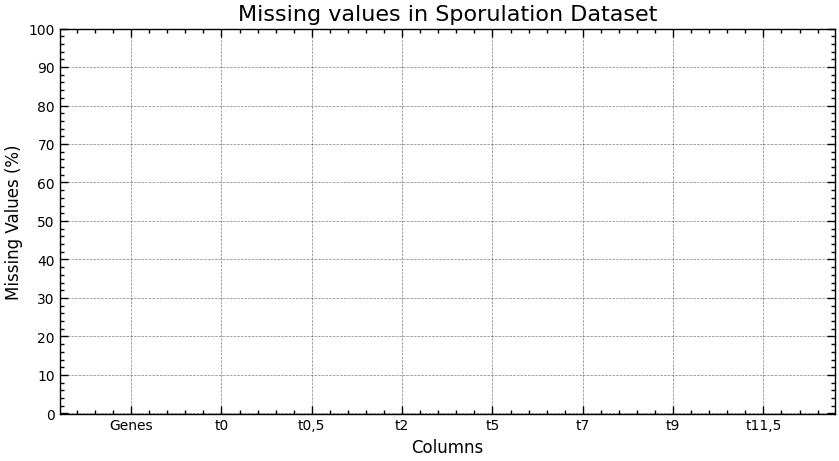

In [34]:
missing = data.isnull().sum() # Compute the sum of True values for each column
missing = missing / data.shape[0]
# Plot the results
plt.bar(x=missing.index, height=missing.values)
plt.title('Missing values in Sporulation Dataset')
plt.ylabel('Missing Values (%)')
plt.yticks(range(0, 110, 10))
plt.xlabel('Columns')
plt.show()

We've not found any missing values in the dataset. Since data is given as an `object` type (string), we must convert all the rows except for the first one to `float`. 

In [35]:
# Now that we know there are not any NA values, convert the string values 
# to float: Replace ',' with '.' and change data type
genes_col = data['Genes']

# Step 2: Drop the 'Genes' column from the DataFrame
data = data.drop(columns=['Genes'])

# Step 3: Replace commas with periods and convert the remaining columns to float
data = data.replace(',', '.', regex=True).astype(float)

# Step 4: Paste the 'Genes' column back into the DataFrame
data['Genes'] = genes_col

# Step 5: Move 'Genes' column to the first position
data = data[['Genes'] + [col for col in data.columns if col != 'Genes']]

data.dtypes

0
Genes     object
t0       float64
t0,5     float64
t2       float64
t5       float64
t7       float64
t9       float64
t11,5    float64
dtype: object

2. **Distribution of Gene Expression Levels**

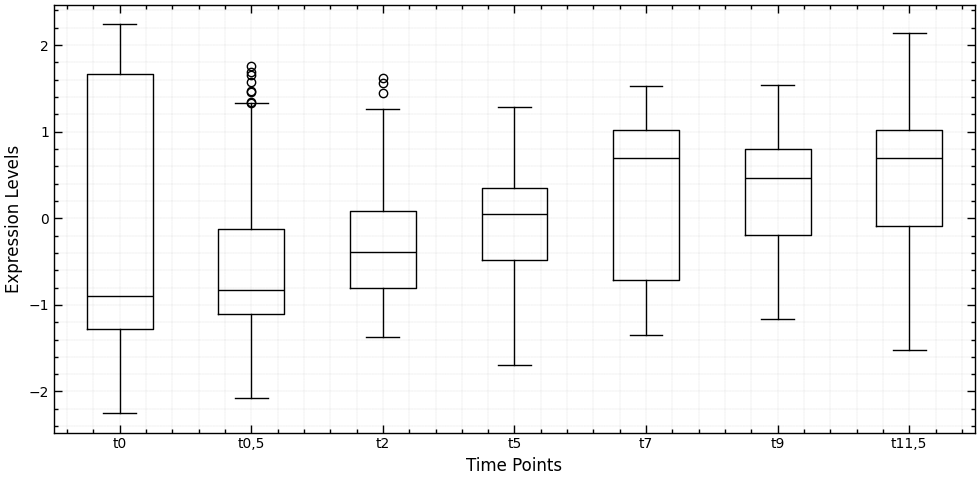

In [36]:
# Create a boxplot for all numerical columns with black color for boxplots
boxprops = dict(color="black")  # Set box color
medianprops = dict(color="black")  # Set median line color
whiskerprops = dict(color="black")  # Set whisker color
capprops = dict(color="black")  # Set cap color

# Create the boxplot
data.boxplot(boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

# Customize the plot
plt.ylabel("Expression Levels", fontsize=12)
plt.xlabel("Time Points", fontsize=12)

# Adjust gridlines and axis
plt.grid(True, which='both', linestyle='--', linewidth=0.1)
plt.xticks()  # Rotate x-ticks for better readability
plt.tight_layout()

plt.savefig("../results/figures/boxplot.pdf")  

# Show the plot
plt.show()

It seems that gene expression level vary over time. At `t=0` the process seems to be unstable, showing data with a higher standard deviation but a lower mean value, indicating that the majority of the genes have negative expression levels, indicating that the expression level at this time points is bellow the refere level. As we progress over time, the mean expression value goes up, until it stabilizes around `t=7`, the dispersion of the data also becomes lower, meaning that the sporulation process is becoming more coordinated. At `t=0.5` and `t=2` there are a few genes that are over-expressed.  

3. **Correlation between Time Points**

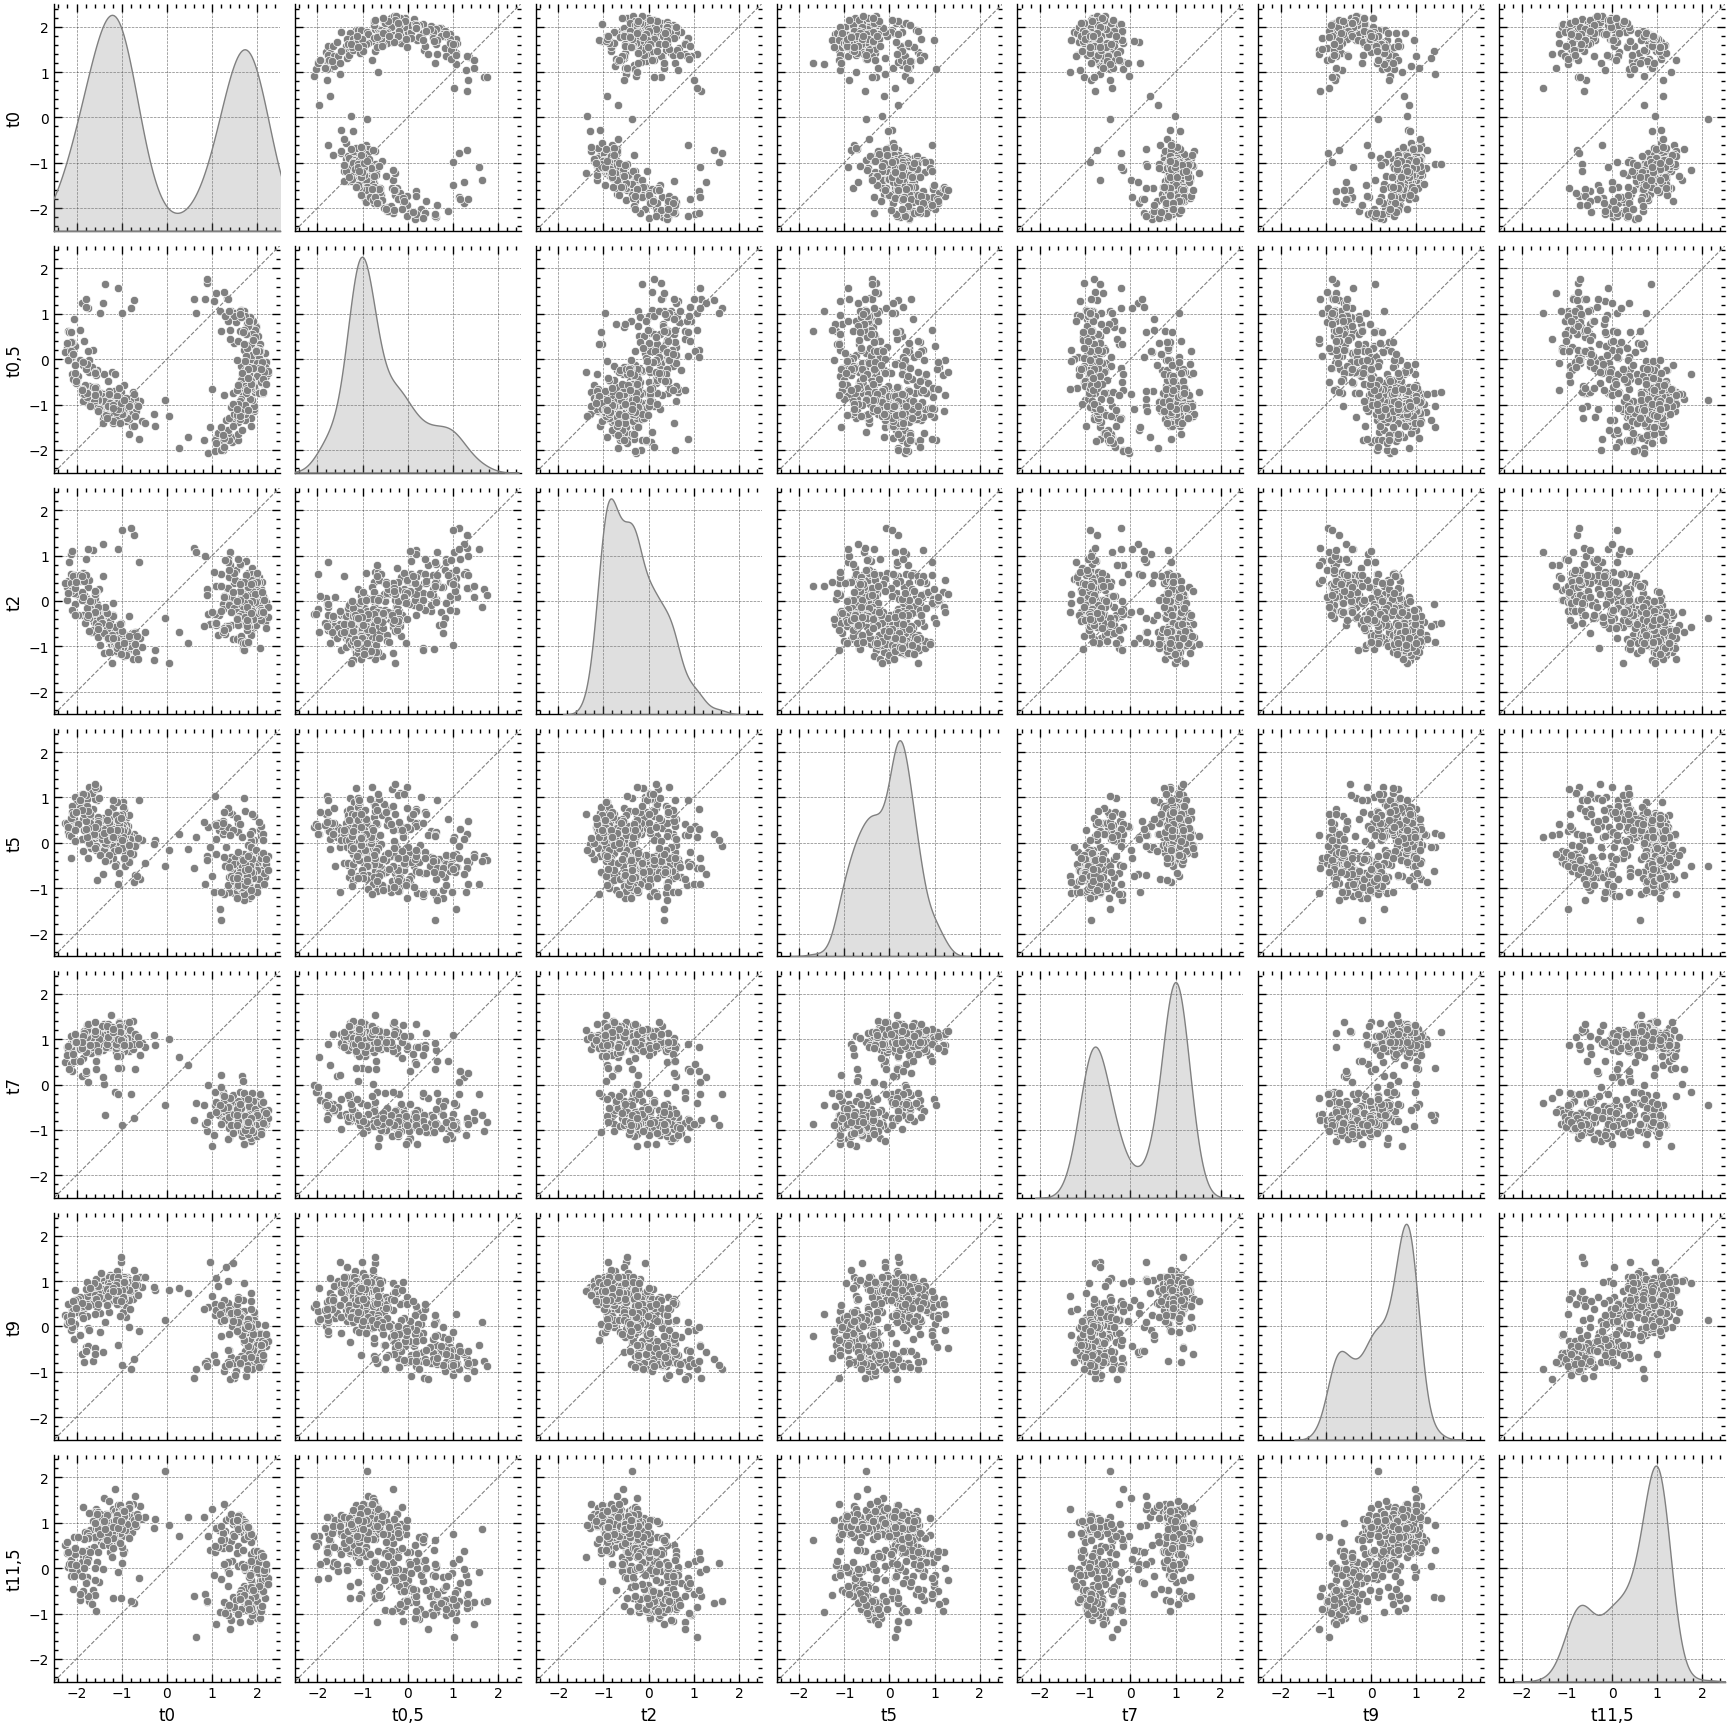

In [37]:
# Set a range
expression_range = [-2.5, 2.5]

# Set the color palette for the data points (grey for data, black for axes)
grey_palette = sns.color_palette(["grey"])

# Create the pairplot with grey data points and KDE plots
pairplot = sns.pairplot(data[data.columns[1:]], diag_kind='kde', plot_kws={'color':'grey'}, diag_kws={'color':'grey'})

# Customize each axis to vary from -2 to 2
for i, ax in enumerate(pairplot.axes.flatten()):
    row_idx, col_idx = divmod(i, len(pairplot.axes))  # Get row and column index

    # Set axis limits and ticks
    ax.set_xlim(expression_range)
    ax.set_ylim(expression_range)
    ax.set_xticks(np.arange(-2, 3, 1))
    ax.set_yticks(np.arange(-2, 3, 1))

    # Change tick and axis label colors to black
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')

    # Add the x = y line only if it's not on the diagonal
    if row_idx != col_idx:
        ax.plot(expression_range, expression_range, ls='--', color='grey', linewidth='0.8')


# Adjust the layout and spacing
plt.subplots_adjust(top=1.1)  
plt.tight_layout()
plt.savefig("../results/figures/pairplot.pdf")  

plt.show()


The main objective of including a pairplot is to represent the variation of gene expression at one timestamp compared to other. The grey discontinuous line is plotted to represent the path that gene expression data would follow if it shared a lineal correlation between the two timestamps plotted, if a data points falls into this line, `x=y`, that implies it has the same expression level of the two timestamps plotted, implying this gene might be involved in some sporulation over time.

4. **Clustered Heatmap**

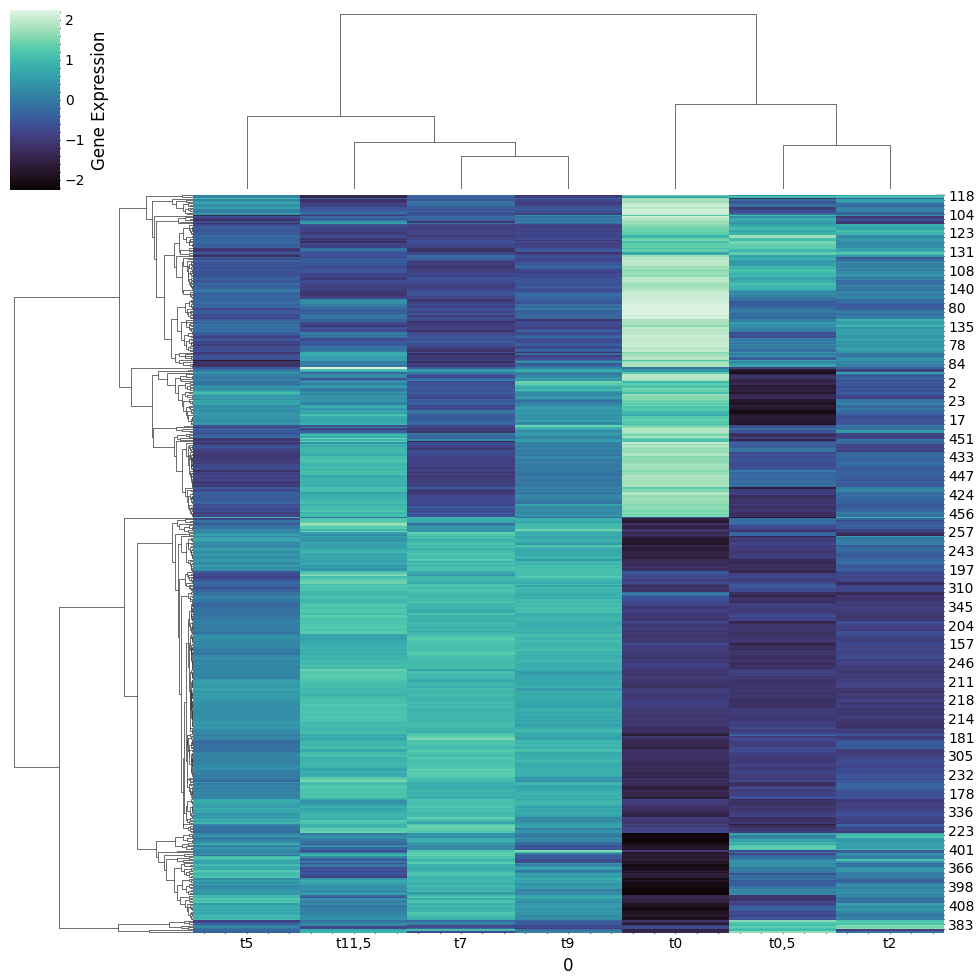

In [38]:
# Create a clustered heatmap with customization
sns.clustermap(data[data.columns[1:]], 
               method='average',       # Hierarchical clustering method
               metric='correlation',     # Distance metric
               z_score=None,           # No z-score normalization
               standard_scale=None,    # No standard scaling
               figsize=(10, 10),       # Figure size
               cbar_kws={'label': 'Gene Expression'},  # Customize color bar
               row_cluster=True,       # Cluster rows
               col_cluster=True,       # Cluster columns
               dendrogram_ratio=0.2,   # Ratio for dendrogram
               cbar_pos=(0.02, 0.8, 0.05, 0.18),  # Position of color bar
               cmap='mako')         # Custom color map
plt.xlabel(" ")
plt.savefig("../results/figures/clustered_heatmap.pdf")  
# Show the heatmap
plt.show()

This clustered heatmap, applies hierarchical clustering to both axis, X (*timestamps*), and Y, (*Gene Expression Levels*). The clustering produced along the X-axis supports out previous hypothesis formulated in the *boxplot* section. Timestamps `t11,5`, `t9`, and `t7` are closely related, as seen in the dendrogram, this is because the gene expression levels are similar, meaning the sporulation process stabilized by that time. `t0` is the last timestamp to join the dendrogram, indicating that the sporulation process at that time was unstable, and gene expression levels have not coordinated yet.

The Y-axis joins genes with similar expression levels, this is useful since we can also see two main groups at `t0`, one, with high expression levels, and the other, with lower values. This two groups get mixes as time progresses. We may also notify that most genes that were really active during `t0` keep low expression levels for the rest of the sporulation process.

4. **Normalization** 

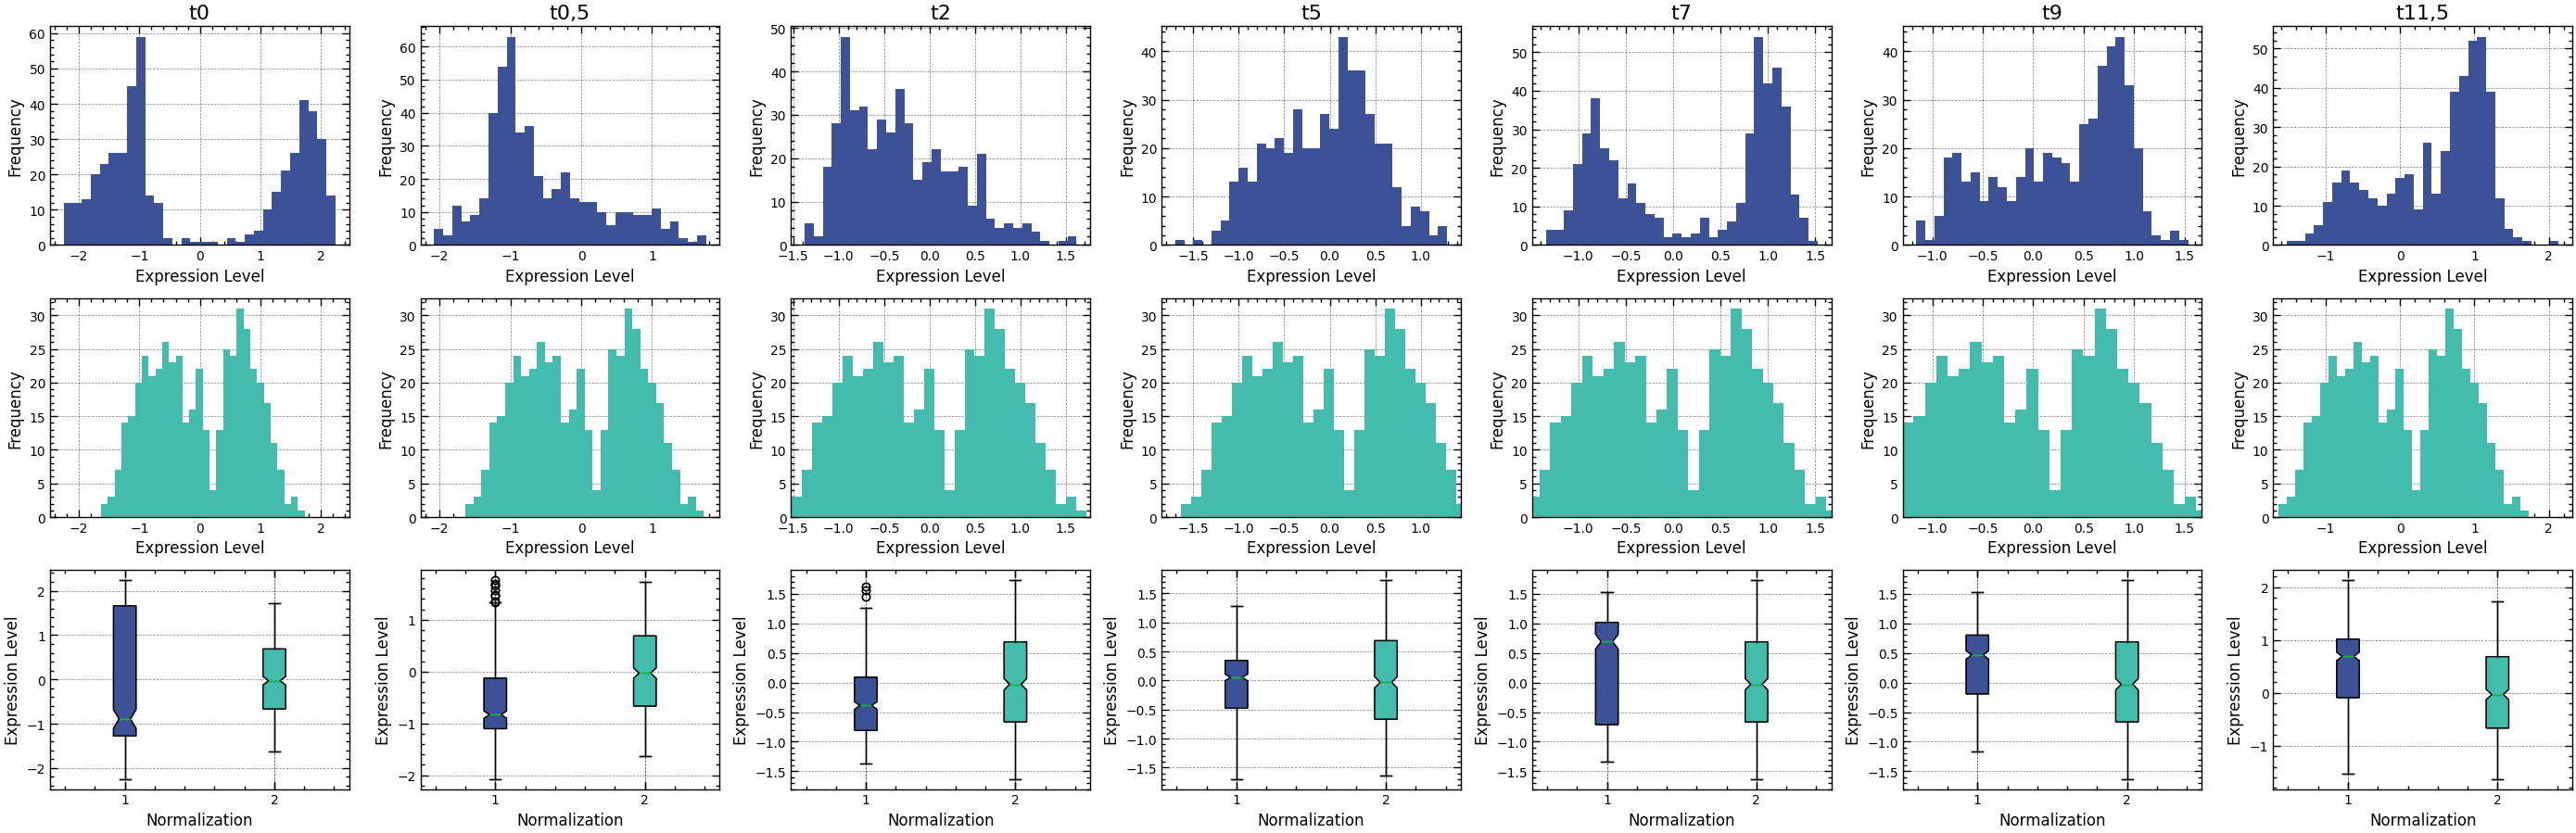

In [39]:
# Assuming `genes_col` is the 'Genes' column from the original data
# and is a Series or DataFrame with the same length as `data`.

def quantile_normalize(df_input):
    """
    Perform quantile normalization on a pandas DataFrame.
    """
    # Make a copy to avoid modifying the original data
    df = df_input.copy()
    
    # Rank the data
    sorted_df = pd.DataFrame(np.sort(df.values, axis=0), 
                             index=df.index, 
                             columns=df.columns)
    
    # Compute the mean of each row across columns
    mean_ranks = sorted_df.mean(axis=1)
    
    # Get the ranks of the original data
    ranks = df.rank(method='min', axis=0).astype(int)
    
    # Map the ranks to the mean ranks
    df_normalized = df.copy()
    for col in df.columns:
        rank_to_mean = dict(zip(sorted_df[col].rank(method='min').astype(int), mean_ranks))
        df_normalized[col] = df[col].rank(method='min').astype(int).map(rank_to_mean)
    
    return df_normalized

def normalize_data_and_plot(data: pd.DataFrame, columns_to_normalize: list, method: str = 'StandardScaler'):
    """
    Normalizes the specified columns in the dataset using the specified method, 
    plots pre- and post-normalization data with shared x-axis range, and includes
    a boxplot for both sets of data.

    Parameters:
    - data: pd.DataFrame, the dataset containing gene expression data
    - columns_to_normalize: list, list of column names that will be normalized
    - method: str, normalization method ('StandardScaler', 'MinMaxScaler', 'Quantile')
    
    Returns:
    - normalized_data: pd.DataFrame, the dataframe with normalized values for the specified columns
    """
    
    # Separating the columns to normalize
    pre_norm_data = data[columns_to_normalize].copy()
    
    # Applying normalization
    if method == 'StandardScaler':
        scaler = StandardScaler()
        normalized_values = scaler.fit_transform(pre_norm_data)
        normalized_data = pd.DataFrame(normalized_values, columns=columns_to_normalize, index=data.index)
    elif method == 'MinMaxScaler':
        scaler = MinMaxScaler()
        normalized_values = scaler.fit_transform(pre_norm_data)
        normalized_data = pd.DataFrame(normalized_values, columns=columns_to_normalize, index=data.index)
    elif method == 'Quantile':
        normalized_data = quantile_normalize(pre_norm_data)
    else:
        raise ValueError(f"Unknown normalization method: {method}")
    
    # Plotting pre- and post-normalization data
    fig, axes = plt.subplots(nrows=3, ncols=len(columns_to_normalize), figsize=(4 * len(columns_to_normalize), 10))
    #fig.suptitle("Pre- and Post-Normalization Comparison", fontsize=16)
    
    for i, column in enumerate(columns_to_normalize):
        # Pre-normalization plot
        axes[0, i].hist(pre_norm_data[column], bins=30, color='#3d5296', alpha=1)
        axes[0, i].set_title(f'{column}')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].set_xlabel('Expression Level')
        
        # Getting the x-axis limits from pre-normalization data
        x_min, x_max = axes[0, i].get_xlim()
        
        # Post-normalization plot
        axes[1, i].hist(normalized_data[column], bins=30, color='#44bcad', alpha=1)
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_xlabel('Expression Level')
        axes[1, i].set_xlim(x_min, x_max)
        
        # Boxplot for pre- and post-normalization
        axes[2, i].boxplot([pre_norm_data[column], normalized_data[column]], patch_artist=True, notch=True)
        axes[2, i].set_xticklabels(['Pre', 'Post'])
        axes[2, i].set_ylabel('Expression Level')
        axes[2, i].set_xlabel('Normalization')
        # Coloring the boxplots
        boxplots = axes[2, i].boxplot([pre_norm_data[column], normalized_data[column]], 
                                      patch_artist=True, notch=True)
        boxplots['boxes'][0].set_facecolor('#3d5296')  # Pre-normalization box
        boxplots['boxes'][1].set_facecolor('#44bcad')  # Post-normalization box

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('../results/figures/normalization.pdf')
    plt.show()

    return normalized_data


# Normalizing the data
data_normalized = normalize_data_and_plot(data=data, columns_to_normalize=data.columns[1:], method='Quantile')

# Paste the 'Genes' column back into the normalized DataFrame
data_normalized['Genes'] = data['Genes'].values  # Use aligned indices to prevent NaN values

# Move 'Genes' column to the first position
data_normalized = data_normalized[['Genes'] + [col for col in data_normalized.columns if col != 'Genes']]


In [40]:
data_normalized.head()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
1,YAL025C,0.407328,-1.276938,0.078875,0.581050,-0.632480,-0.027212,0.373993
2,YAL036C,0.352812,-1.139188,-0.238283,-0.265689,-0.617564,1.558586,-0.359854
3,YAL040C,0.557631,0.078875,0.561428,-0.830143,-0.780908,1.508041,-0.959676
4,YDL037c,0.720408,-0.975234,-0.003279,1.316319,-0.348820,-0.764539,-0.814066
5,YDR184C,0.471201,-1.045429,-0.344901,-0.273162,-0.613577,1.452409,-0.582315


### Clustering with K-Means

In the original paper, the implemented K-Means had these characteristics included:
1. **Fixed *k* value**. The number if clusters is fixed to 7, even though the paper explores the performance of the algorithm for different values of *k*. 
> *"... Chu et al. (1998) advocated grouping the expressed genes into seven temporal classes on biological grounds. Following Chu et al.(1998), the number of clusters was set to seven in each case..."*
2. **Correlation as distance measure (?)**. The paper does not explicitly mention the distance measure applied for K-Means, however, in the UPGMA section, it mentions that the distance between a pair of genes would be computed as the inverse of the statistical correlation between them.
> *"... The ‘distance’ between genes x and y were taken to be d(x , y) = 1 − | corr(x , y)|, where corr(x , y) is the statistical correlation between the expression profiles of x and y..."*
3. **Initial initial centroids**. The paper mentions that *K-Means* initial centroids for the sporulation dataset were taken from the results of the UPGMA algorithm. 
> *"... K-means is a popular algorithm that uses a reasonable objective criterion. However, it could be sensitive to the choice of the initial cluster centers. For the simulated data sets, we have observed that the K-means algorithm failed when the initial centers were taken to be the cluster means obtained using UPGMA, and, subsequently, we had used the cluster means from Diana for it to work ..."*

In order to replicate the results from the paper as faithfully as possible, we must then complete all these tasks:
- *Obtain the centroids for each k-value we will use to measure the performance of K-Means*. For these, we must compute the UPGMA algorith with `method=average` with a initial distance matrix computed using $d(x , y) = 1 − | corr(x , y)|$ and saving each centroid for every iteration. 

#### Centroids

The original paper that applied the K-Means algorithm leaves some questions unanswered, this forces us to perform a hyperparameter tuning on the K-Means model using the sporulation dataset, and then, compare our results with the ones obtained in the paper. To ensure a fair comparison, our model will be as similar as possible to the one applied in the paper, so we will *select the centroids of the model* using the UPGMA algorithm with the original distance matrix computed using the inverse correlation score between genes and the average method for updating distances between merged clusters. 

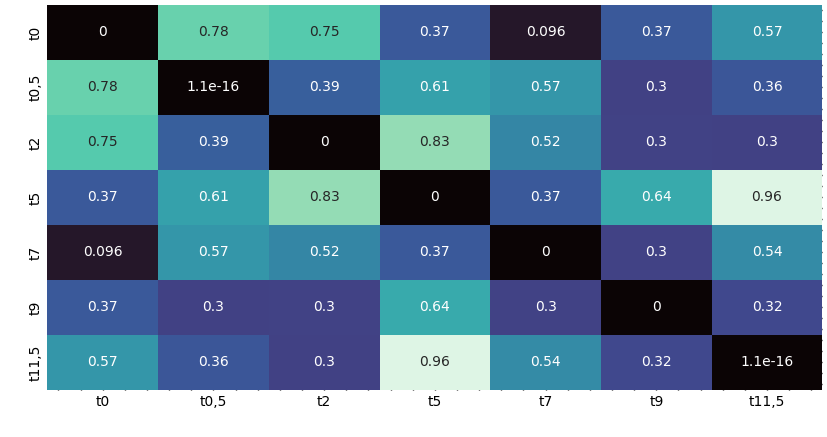

In [41]:
def visualize_distmatrix_corr(X: np.ndarray) -> None:
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    distance_matrix = 1 - np.abs(corr_matrix)
    # Translate it to a Dataframe
    corr_mat = pd.DataFrame(distance_matrix, 
                            columns=data.columns[1:], index=data.columns[1:])
    # Plot the heatmap
    sns.heatmap(corr_mat, cmap='mako', annot=True, cbar=False)
    plt.xlabel(" ")
    plt.ylabel(" ")
    plt.savefig('../results/figures/heatmap_correlation.pdf')

visualize_distmatrix_corr(X = data[data.columns[1:]].values)

The following function provides the cluster's centers computed by the UPGMA algorithm given a *K-Value*. UPGMA creates a binary tree that merges clusters step by step. Initially, we have n clusters (one for each point), and the process continues until all points are merged into a single cluster. The goal is to identify the step when there are exactly K clusters remaining and extract their centroids. To achieve this, we can leverage the **dendrogram cutting** capability provided by `scipy.cluster.hierarchy.fcluster`, which allows us to cut the dendrogram to obtain K clusters.

In [42]:
def get_centroids_for_K(Z: np.ndarray, X: np.ndarray, K: int) -> List[np.ndarray]:
    """
    Returns the centroids of clusters when there are exactly K clusters in UPGMA clustering.
    
    Parameters:
    Z (np.ndarray): The linkage matrix from hierarchical clustering.
    X (np.ndarray): The original data matrix (n samples x d features).
    K (int): The number of clusters to extract centroids for.

    Returns:
    List[np.ndarray]: A list of centroids (mean vectors) for the K clusters.
    """
    # Assign each data point to a cluster when we have exactly K clusters
    labels = fcluster(Z, K, criterion='maxclust')

    centroids = []
    for cluster_num in range(1, K+1):
        # Find all points that belong to the current cluster
        cluster_points = X[labels == cluster_num]
        # Calculate the centroid (mean) of the cluster
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
    
    return centroids

The following function applied the previously defined to a given list of K values. It calculated the distance matrix based on the inverse correlation of the genes, and leverages the average method for distance updating, as specified in the paper. 

In [43]:
def save_centroids_for_K_list(X: np.ndarray, K_list: np.ndarray, save_csv: bool = True, csv_path: str = "./centroids.csv", verbose:bool = False) -> pd.DataFrame:
    """
    Calculate and save centroids for different values of K into a CSV file.
    The centroids will be saved as arrays of floats in string format.
    
    Parameters:
    Z (np.ndarray): The linkage matrix from hierarchical clustering.
    X (np.ndarray): The original data matrix (n samples x d features).
    K_list (np.ndarray): List or array of K values (number of clusters).
    csv_path (str): The path where the CSV file should be saved.

    Returns:
    None
    """
    # Compute the condensed correlation distance matrix
    condensed_corr_mat = pdist(X, metric='correlation')

    # Apply UPGMA hierarchical clustering (average linkage)
    Z = linkage(condensed_corr_mat, method='average')

    # List to store all results
    results = []
    
    # Iterate through each K value
    for K in K_list:
        # Get centroids for the current K
        centroids = get_centroids_for_K(Z, X, K)
        if verbose: 
            print(f'Centroids for k={K}')
            [print(f'C{idx}: {centroid} \n') for idx, centroid in enumerate(centroids)]
        # Store each centroid and K value
        for cluster_idx, centroid in enumerate(centroids):
            # Save centroid as a string representing an array of floats
            results.append({
                'K': K,
                'Cluster': cluster_idx + 1,  # Cluster numbering (1-based index)
                'Centroid': np.array2string(centroid, separator=',', precision=6).replace('\n', '')  # Save as array
            })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(results)
    if save_csv:
        # Save to CSV
        df.to_csv(csv_path, index=False)
        print(f"Centroids saved to {csv_path}")
    return df

Now, we store all the centroids for a whide range of K values, in case we are inned of further anaylsis.

In [44]:
K_list = np.arange(2, 51, 1)
# Extract centroids for unprocessed data
df = data[data.columns[1:]].values
_ = save_centroids_for_K_list(X=df, K_list=K_list, csv_path='../results/unprocessed_data_UPGMA_centroids.csv')
# Extract centroids for normalized data
df = data_normalized[data_normalized.columns[1:]].values
_ = save_centroids_for_K_list(X=df, K_list=K_list, csv_path='../results/normalized_data_UPGMA_centroids.csv')

Centroids saved to ../results/unprocessed_data_UPGMA_centroids.csv
Centroids saved to ../results/normalized_data_UPGMA_centroids.csv


Finally, we code a function to access these csv files and return a dictionary of the given K values and its centroids. 

In [45]:
def load_centroids_from_csv(K_list: List[int], csv_path: str) -> Dict[int, List[List[float]]]:
    """
    Load centroids from a CSV file for a given list of K values.
    
    Parameters:
    K_list (List[int]): List of K values for which to extract centroids.
    csv_path (str): Path to the CSV file containing the centroids.

    Returns:
    Dict[int, List[List[float]]]: A dictionary where the key is K and the value 
                                  is a list of centroids for that K.
    """
    # Load the CSV into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Initialize dictionary to store centroids for each K
    centroids_dict = {}
    
    # Iterate over the list of K values
    for K in K_list:
        # Filter the DataFrame for the current K value
        df_filtered = df[df['K'] == K]
        
        # Extract centroids as lists of floats
        centroids = []
        for centroid_str in df_filtered['Centroid']:
            # Convert the string representation of the centroid back to a list of floats
            centroid = ast.literal_eval(centroid_str)
            centroids.append(centroid)
        
        # Store the list of centroids in the dictionary
        centroids_dict[K] = centroids
    
    return centroids_dict

#### K-Means

The K-Means algorithm exploration will consist of two sections where we will evaluate its performance for different k-values with two distinct measures:
1. **Silhouette Score**. This validation metric will be used to determine the amount of clusters and the affinity of assigned points to their respective clusters.
2. **Average Proportion of Non-Overlapping**. This validation metric was implemented to perform a fair comparison of our KMeans implementation and the papers'. This metric measures the robustness of the algorithm when removing timestamps from the original dataset, determining the amount of points that stay in the same cluster after these changes.

##### Silhouette Score

First, we will show the average silhouette score for different k values, paying close attention to the distribution of points among clusters.

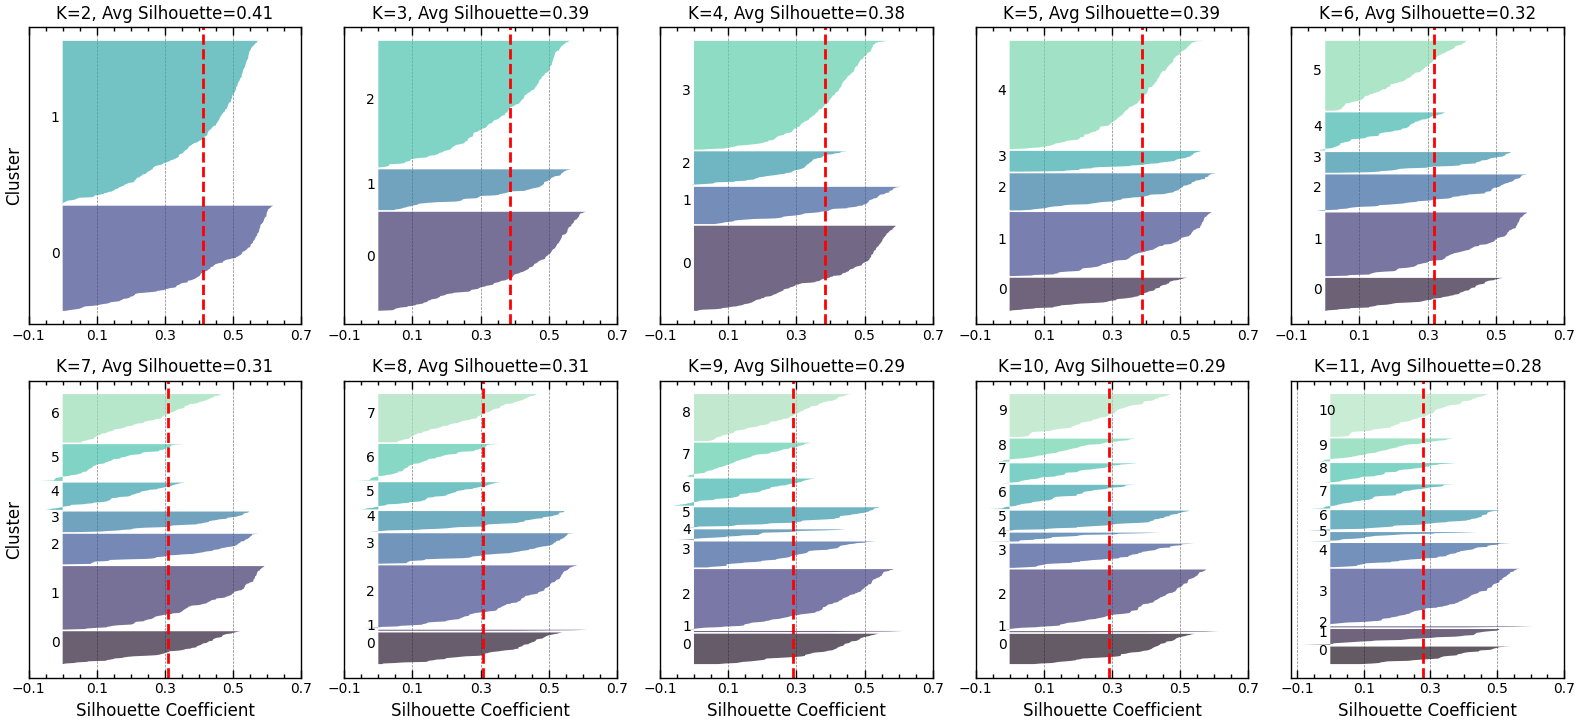

In [46]:
def kmeans_silhouette_analysis(data: pd.DataFrame, k_centroids_dict: dict, title:str = 'Silhouette Analysis for K-Means Clustering'):
    """
    Performs KMeans clustering and silhouette analysis for a range of K values, using 
    the specified initial centroids for each K, returning a DataFrame with the average 
    silhouette score for each K and generating silhouette plots for each K.

    Parameters:
    - data: pd.DataFrame, the dataset containing the feature values.
    - k_centroids_dict: dict, where the keys are K values and the values are the initial centroids for that K.

    Returns:
    - results_df: pd.DataFrame, containing the K values and their corresponding average silhouette score.
    """
    
    X = data.values  # Convert DataFrame to numpy array for KMeans
    
    # Initialize the DataFrame to store results
    results = {
        'K': [],
        'Silhouette Avg': []
    }
    
    # Create a figure for the subplots (2 rows x 5 columns for a maximum of 10 positions)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))  # Adjusted figure size for 2x5 grid
    fig.suptitle(title, fontsize=12)
    
    # Flatten the axes array to easily index it
    axes = axes.flatten()

    for idx, (K, initial_centroids) in enumerate(k_centroids_dict.items()):
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=K, init=initial_centroids, n_init=1, random_state=42)
        kmeans.fit(X)
        labels = kmeans.labels_
        
        # Compute silhouette score and silhouette values
        silhouette_avg = silhouette_score(X, labels)
        silhouette_vals = silhouette_samples(X, labels)
        
        # Store results
        results['K'].append(K)
        results['Silhouette Avg'].append(silhouette_avg)
        
        # Get colors from the 'mako' palette for each cluster
        colors = sns.color_palette("mako", K)
        
        # Plot the silhouette scores
        ax = axes[idx]
        y_lower = 10
        for i in range(K):
            ith_cluster_silhouette_vals = silhouette_vals[labels == i]
            ith_cluster_silhouette_vals.sort()
            size_cluster_i = ith_cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            color = colors[i]  # Use the mako palette color for each cluster
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, facecolor=color, alpha=0.7)
            ax.text(-0.035, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 2
        
        ax.set_title(f'K={K}, Avg Silhouette={silhouette_avg:.2f}', fontsize=12)
        
        if idx >= 5: ax.set_xlabel('Silhouette Coefficient', fontsize=12) 
        if idx % 5 == 0: ax.set_ylabel('Cluster', fontsize=12)
        ax.set_xticks(np.arange(-0.1, .8, 0.2))
        ax.xaxis.set_tick_params(labelsize=10)
        ax.set_yticks([])
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # Remove the 10th (bottom-right) subplot to avoid a hollow space
    #fig.delaxes(axes[-1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.savefig('../results/figures/silhouette_analysis.pdf')
    plt.show()
    
    # Convert results to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df

K_list = [2,3,4,5,6,7,8,9,10,11]

centroids_normalized = load_centroids_from_csv(K_list=K_list, csv_path='../results/normalized_data_UPGMA_centroids.csv')
results_normalized = kmeans_silhouette_analysis(data_normalized[data_normalized.columns[1:]], centroids_normalized, title='')

Now, we may plot the average silhouette analysis for each K value.

Silhouette Score for K=2: 0.4121
Silhouette Score for K=3: 0.3864
Silhouette Score for K=4: 0.3832
Silhouette Score for K=5: 0.3877
Silhouette Score for K=6: 0.3190
Silhouette Score for K=7: 0.3085
Silhouette Score for K=8: 0.3056
Silhouette Score for K=9: 0.2905
Silhouette Score for K=10: 0.2910
Silhouette Score for K=11: 0.2782


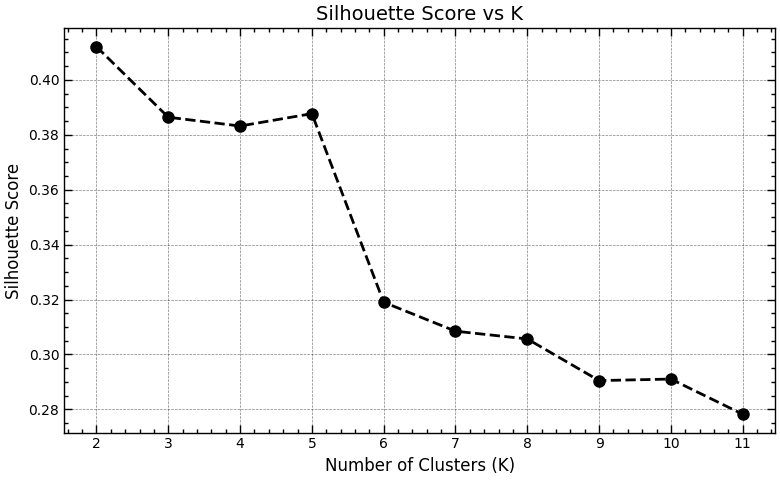

In [47]:
X = data_normalized[data_normalized.columns[1:]].values

# Define the range of K values to try
k_values_to_try = np.arange(2, 12)

# Store silhouette scores for each K value
silhouette_scores = []

# Loop over each K value
for k in k_values_to_try:
    # Get the initial centroids for this K value (assuming centroids_normalized is predefined)
    initial_centroids = centroids_normalized.get(k)
    
    # Run K-Means with the loaded centroids for the given K
    kmeans = KMeans(n_clusters=k, init=centroids_normalized[k], n_init=1, random_state=42)
    kmeans.fit(X)
    
    # Predict the cluster labels
    labels = kmeans.labels_
    
    # Calculate the silhouette score using the default 'euclidean' metric
    score = silhouette_score(X, labels, metric='euclidean')
    silhouette_scores.append(score)
    
    print(f"Silhouette Score for K={k}: {score:.4f}")

# Plot the silhouette scores for each K value
plt.figure(figsize=(8, 5))
plt.plot(k_values_to_try, silhouette_scores, linestyle='--', marker='o', markersize=8, color='black', label='Silhouette Score')

# Set plot title and labels
plt.title('Silhouette Score vs K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(k_values_to_try, fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In addition, we can also add the execution time.

Silhouette Score for K=2: 0.4121, Computation Time: 0.0025 seconds
Silhouette Score for K=3: 0.3864, Computation Time: 0.0239 seconds
Silhouette Score for K=4: 0.3832, Computation Time: 0.0269 seconds
Silhouette Score for K=5: 0.3877, Computation Time: 0.0233 seconds
Silhouette Score for K=6: 0.3190, Computation Time: 0.0350 seconds
Silhouette Score for K=7: 0.3085, Computation Time: 0.0416 seconds
Silhouette Score for K=8: 0.3056, Computation Time: 0.0241 seconds
Silhouette Score for K=9: 0.2905, Computation Time: 0.0270 seconds
Silhouette Score for K=10: 0.2910, Computation Time: 0.0436 seconds
Silhouette Score for K=11: 0.2782, Computation Time: 0.0348 seconds


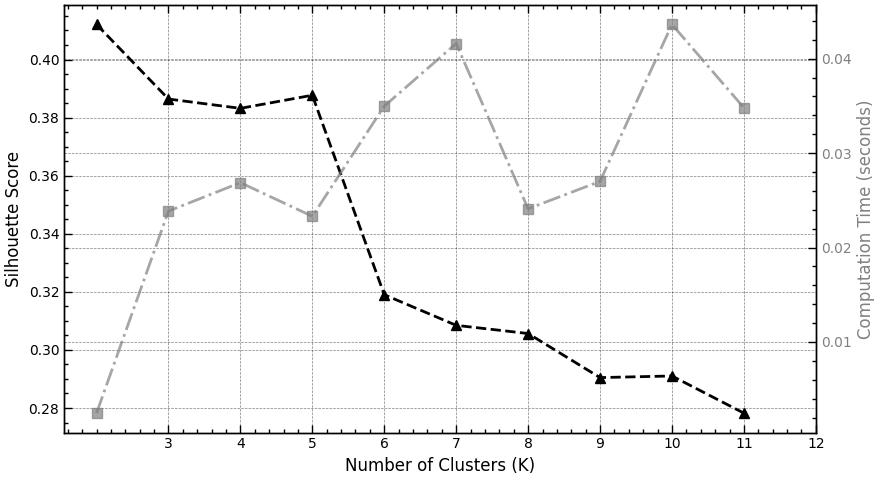

In [48]:
# Define the range of K values to try
k_values_to_try = np.arange(2, 12)

# Store silhouette scores and computation times for each K value
silhouette_scores = []
computation_times = []

# Loop over each K value
for k in k_values_to_try:
    # Get the initial centroids for this K value (assuming centroids_normalized is predefined)
    initial_centroids = centroids_normalized.get(k)
    
    # Start timing the KMeans execution
    start_time = time.time()
    
    # Run K-Means with the loaded centroids for the given K
    kmeans = KMeans(n_clusters=k, init=centroids_normalized[k], n_init=1, random_state=42)
    kmeans.fit(data_normalized[data_normalized.columns[1:]].values)
    
    # End timing and calculate the computation time
    end_time = time.time()
    computation_time = end_time - start_time
    computation_times.append(computation_time)
    
    # Predict the cluster labels
    labels = kmeans.labels_
    
    # Calculate the silhouette score using the default 'euclidean' metric
    score = silhouette_score(X, labels, metric='euclidean')
    silhouette_scores.append(score)
    
    print(f"Silhouette Score for K={k}: {score:.4f}, Computation Time: {computation_time:.4f} seconds")

# Plot the silhouette scores and computation times
fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot silhouette score on the left Y-axis
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Silhouette Score', color='black')
ax1.plot(k_values_to_try, silhouette_scores, linestyle='--', marker='^', markersize=7, color='black', label='Silhouette Score')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second Y-axis for the computation time
ax2 = ax1.twinx()  
ax2.set_ylabel('Computation Time (seconds)', color='grey')  
ax2.plot(k_values_to_try, computation_times, linestyle='-.', marker='s', markersize=7, color='grey', alpha=.7, label='Computation Time')
ax2.tick_params(axis='y', labelcolor='grey')

# Set plot title and labels
#plt.title('Silhouette Score')

# Show the plot with both Y-axes
fig.tight_layout()  
plt.grid(True)
plt.xticks(np.arange(3,13,1))
plt.savefig('../results/figures/silhouette_against_k.pdf')
plt.show()


##### Average proportion of non overlap

The main issue of this implementation is that the cluster's labels from the KMeans algorithm of the scikit-learn library assigns the cluster's labels arbitrarily. This means that 2 points could be grouped togeather in the same cluster for different versions of the dataset (full and removing some timestamps), but the 'name' assigned to the cluster for each experiment could change, meaning that the algorithm would think that the points changed cluster, even though that is incorrect. This is an example:

- Full Dataset Clustering (KMeans on the full dataset):

```yaml
Data Points: [A, B, C, D, E, F]
Clusters:    [0, 0, 1, 1, 2, 2]  # KMeans assigns labels arbitrarily
```
A and B are in Cluster 0.
C and D are in Cluster 1.
E and F are in Cluster 2.

- Reduced Dataset Clustering (KMeans after removing a timestamp):

```yaml
Data Points: [A, B, C, D, E, F]
Clusters:    [1, 1, 0, 0, 2, 2]  # KMeans assigns different labels
```
A and B are still grouped together, but they now have label 1 (instead of 0).
C and D are still grouped together, but they now have label 0 (instead of 1).
E and F are still in Cluster 2 (no change in label).

Even though the labels have changed, the groupings of the data points haven’t changed—A and B are still in the same cluster, as are C and D, and E and F. The **Hungarian algorithm** finds the best mapping between the clusters in the full dataset and the reduced dataset. In this case, it would align:

- Cluster 0 in the full dataset with Cluster 1 in the reduced dataset.
- Cluster 1 in the full dataset with Cluster 0 in the reduced dataset.

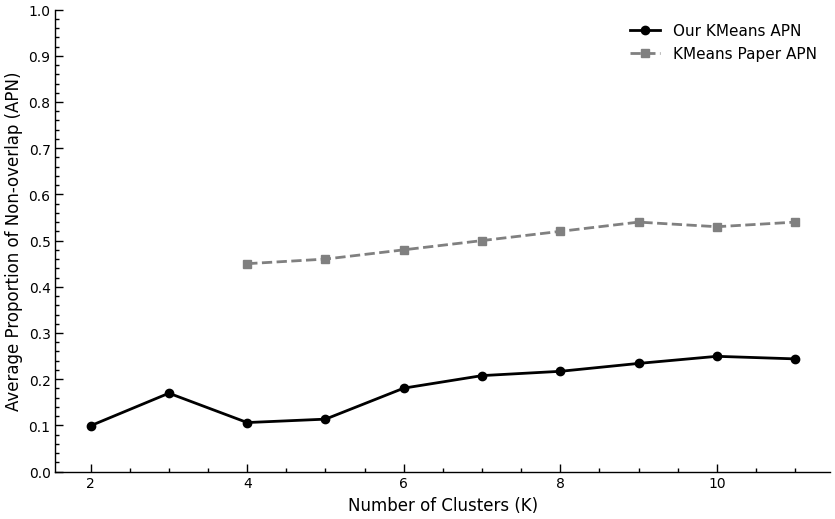

In [49]:
# Note: This metric is really messy to compute since we have to remove ne timestamp every iteration to compute it. 
# The initial centroids given by the UPGMA have (K, timestamps) dimensions: If k = 7 then we have 7 points with given by 7 coordinates.
# When we remove a timestamp from the dataset, we also have to compute the UPGMA centroids

def average_proportion_non_overlap_from_labels(clusters_full, clusters_reduced_list):
    """
    Computes the average proportion of non-overlap measure from precomputed KMeans labels.

    Args:
    - clusters_full (ndarray): Cluster labels for the full dataset (without any missing time points).
    - clusters_reduced_list (list of ndarrays): List of cluster labels for the reduced datasets (with one time point missing in each).

    Returns:
    - V1 (float): Average proportion of non-overlap.
    """
    M = len(clusters_full)  # Number of genes
    l = len(clusters_reduced_list)  # Number of reduced datasets (time points removed)
    I = l  # Number of time points removed, assuming one time point per reduced dataset
    total_non_overlap = 0

    # Get the unique clusters in the full dataset
    unique_clusters_full = np.unique(clusters_full)

    for clusters_reduced in clusters_reduced_list:
        # Align cluster labels between clusters_full and clusters_reduced
        # Compute the confusion matrix between clusters_full and clusters_reduced
        cm = confusion_matrix(clusters_full, clusters_reduced)
        
        # Use the Hungarian algorithm to find the best matching
        row_ind, col_ind = linear_sum_assignment(-cm)
        
        # Create a mapping from clusters_reduced labels to clusters_full labels
        label_mapping = {col: row for row, col in zip(row_ind, col_ind)}
        
        # Map the clusters in clusters_reduced to the clusters in clusters_full
        clusters_reduced_aligned = np.array([label_mapping[label] if label in label_mapping else -1 for label in clusters_reduced])
        
        # For each gene, compute the non-overlap proportion
        for g in range(M):
            C_g0 = clusters_full[g]
            C_gi = clusters_reduced_aligned[g]
            
            # Genes in cluster C_g0 in the full dataset
            genes_in_C_g0 = np.where(clusters_full == C_g0)[0]
            n_C_g0 = len(genes_in_C_g0)
            
            # Genes in cluster C_gi in the reduced dataset
            genes_in_C_gi = np.where(clusters_reduced_aligned == C_gi)[0]
            
            # Intersection of the two clusters
            intersection = np.intersect1d(genes_in_C_g0, genes_in_C_gi)
            n_intersection = len(intersection)
            
            # Compute the proportion of non-overlap for gene g
            proportion_non_overlap = 1 - (n_intersection / n_C_g0)
            total_non_overlap += proportion_non_overlap

    V1 = total_non_overlap / (M * I)
    return V1

def compute_cluster_reduced_list(X_full, K, centroids_full, time_point_indices):
    """
    Generates the list of cluster labels from datasets where one time point is removed at a time.
    
    Args:
    - X_full (ndarray): Full dataset (without any missing time points).
    - K (int): Number of clusters.
    - centroids_full (ndarray): Initial centroids for the full dataset.
    - time_point_indices (list): List of column indices that correspond to time points in the dataset.
    
    Returns:
    - clusters_full (ndarray): Cluster labels for the full dataset.
    - clusters_reduced_list (list of ndarrays): List of cluster labels for datasets with one time point removed at a time.
    """
    # Step 1: Run KMeans on the full dataset
    kmeans_full = KMeans(n_clusters=K, init=centroids_full[K], n_init=1, random_state=42)
    kmeans_full.fit(X_full)
    clusters_full = kmeans_full.labels_

    clusters_reduced_list = []
    X_reduced_list = []

    # Step 2: For each time point, remove it and run KMeans
    for time_point_index in time_point_indices:
        # Remove the time point from the dataset
        X_reduced = np.delete(X_full, time_point_index, axis=1)

        # Compute the UPGMA initial centroids for the reducted dataset
        # Compute the condensed correlation distance matrix
        condensed_corr_mat = pdist(X_reduced, metric='correlation')

        # Apply UPGMA hierarchical clustering (average linkage)
        Z_reducted = linkage(condensed_corr_mat, method='average')

        # Compute the centroids
        centroids_reducted = get_centroids_for_K(Z=Z_reducted, X=X_reduced, K=K)

        # Run KMeans on the reduced dataset
        kmeans_reduced = KMeans(n_clusters=K, init=centroids_reducted, n_init=1, random_state=42)
        kmeans_reduced.fit(X_reduced)
        
        # Save the cluster labels for this reduced dataset
        clusters_reduced_list.append(kmeans_reduced.labels_)
        X_reduced_list.append(X_reduced)

    return clusters_full, clusters_reduced_list, X_reduced_list


# Assuming you have your full dataset X_full and the centroids centroids_full

# Define the list of time point indices (for example, if the time points are columns 1 to 5)
time_point_indices = [0, 1, 2, 3, 4, 5]

scores = {}
for k in [2,3,4,5,6,7,8,9,10,11]:
    clusters_full, clusters_reduced_list, _ = compute_cluster_reduced_list(X_full=data_normalized[data_normalized.columns[1:]].values, 
                                                                        K=k, centroids_full=centroids_normalized, time_point_indices=time_point_indices)

    scores[k] = average_proportion_non_overlap_from_labels(clusters_full, clusters_reduced_list)

ks = list(scores.keys())
apn_values = list(scores.values())

plt.figure(figsize=(10, 6))

apn_values_paper = np.array([np.nan, np.nan,0.45, 0.46, 0.48, 0.50, 0.52, 0.54, 0.53, 0.54]) # Aprox
ax = plt.subplot(111)
plt.plot(ks, apn_values, marker='o', linestyle='-', color='black', label="Our KMeans APN")
plt.plot(ks, apn_values_paper, marker='s', linestyle='--', color='grey', label="KMeans Paper APN")
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Average Proportion of Non-overlap (APN)", fontsize=12)
plt.grid(False)
plt.yticks(np.arange(0,1.1,0.1))
plt.legend(fontsize=11, frameon=False)
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
plt.savefig('../results/figures/APN.pdf')
plt.show()

##### Average Distance Between Means 

$$
V_2(K) = \frac{1}{MI} \sum_{g=1}^{M} \sum_{i=1}^{l} d\left( \bar{x}_{C_{g,i}}, \bar{x}_{C_{g,0}} \right)
$$

- **$ M $**: Number of genes.
- **$ I $**: Number of time points.
- **$ l $**: Number of reduced datasets (each with one time point removed, so $ l = I $).
- **$ C_{g,0} $**: Cluster containing gene $ g $ in the full dataset.
- **$ C_{g,i} $**: Cluster containing gene $ g $ in the $ i $-th reduced dataset.
- **$ \bar{x}_{C_{g,0}} $**: Mean expression profile of cluster $ C_{g,0} $ in the full dataset.
- **$ \bar{x}_{C_{g,i}} $**: Mean expression profile of cluster $ C_{g,i} $ in the reduced dataset $ i $.
- **$ d(\cdot, \cdot) $**: Distance metric between two mean expression profiles.

This measure computes the average distance between the mean expression profiles of clusters that each gene $ g $ belongs to in the full dataset and each reduced dataset.

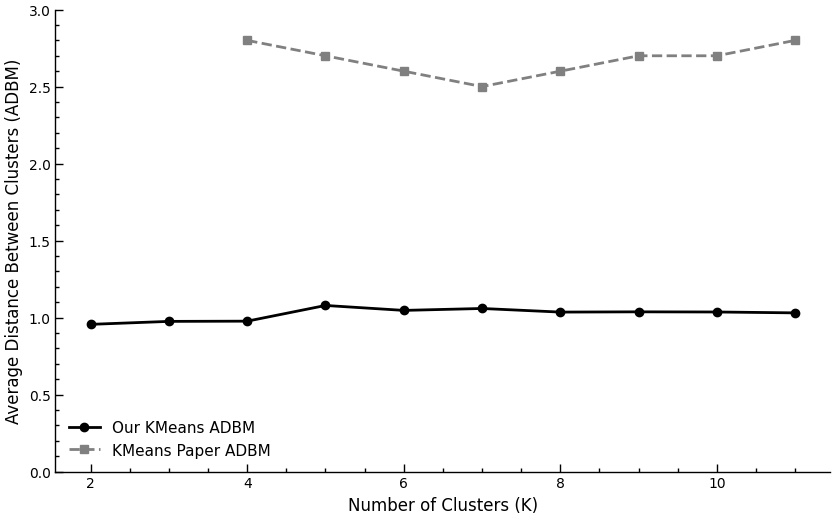

In [50]:
def average_distance_between_means(
    X_full,  # Full expression data (M x I)
    X_reduced_list,  # List of reduced expression datasets (each M x (I - 1))
    clusters_full,  # Cluster labels for the full dataset (length M)
    clusters_reduced_list  # List of cluster labels for reduced datasets (each length M)
):
    """
    Computes the average distance between cluster mean profiles as per V2(K).

    Args:
    - X_full (ndarray): Expression data for the full dataset (genes x time points).
    - X_reduced_list (list of ndarray): List of expression data for reduced datasets.
    - clusters_full (ndarray): Cluster labels for the full dataset.
    - clusters_reduced_list (list of ndarray): List of cluster labels for reduced datasets.

    Returns:
    - V2 (float): Average distance between cluster mean profiles.
    """
    M, I = X_full.shape  # Number of genes and time points
    l = len(X_reduced_list)  # Number of reduced datasets (should be I)
    total_distance = 0.0

    for i in range(l):
        X_reduced = X_reduced_list[i]
        clusters_reduced = clusters_reduced_list[i]

        # Identify which time point was removed
        time_point_removed = i  # Assuming each reduced dataset removes time point i

        # Remove the same time point from X_full for fair comparison
        X_full_reduced = np.delete(X_full, time_point_removed, axis=1)

        # Align cluster labels between clusters_full and clusters_reduced
        # Compute confusion matrix between clusters_full and clusters_reduced
        cm = confusion_matrix(clusters_full, clusters_reduced)
        # Use Hungarian algorithm to find best matching
        row_ind, col_ind = linear_sum_assignment(-cm)
        # Create mapping from clusters_reduced to clusters_full labels
        label_mapping = {col: row for row, col in zip(row_ind, col_ind)}
        # Map clusters_reduced to clusters_full labels
        clusters_reduced_aligned = np.array([label_mapping.get(label, -1) for label in clusters_reduced])

        # For each gene, compute the distance between cluster means
        for g in range(M):
            C_g0 = clusters_full[g]  # Cluster of gene g in full dataset
            C_gi = clusters_reduced_aligned[g]  # Cluster of gene g in reduced dataset

            # Get indices of genes in clusters C_g0 and C_gi
            indices_C_g0 = np.where(clusters_full == C_g0)[0]
            indices_C_gi = np.where(clusters_reduced_aligned == C_gi)[0]

            # Compute mean expression profiles for clusters
            mean_profile_C_g0 = np.mean(X_full_reduced[indices_C_g0], axis=0)
            mean_profile_C_gi = np.mean(X_reduced[indices_C_gi], axis=0)

            # Compute distance between mean profiles
            distance = np.linalg.norm(mean_profile_C_g0 - mean_profile_C_gi)

            total_distance += distance

    V2 = total_distance / (M * I)
    return V2

# Define the list of time point indices (for example, if the time points are columns 1 to 5)
time_point_indices = [0, 1, 2, 3, 4, 5]
scores = {}
for k in [2,3,4,5,6,7,8,9,10,11]:
    clusters_full, clusters_reduced_list, X_reducted_list = compute_cluster_reduced_list(X_full=data[data.columns[1:]].values, 
                                                                                         K=k, centroids_full=centroids_normalized, time_point_indices=time_point_indices)

    scores[k] = average_distance_between_means(X_full=data_normalized[data_normalized.columns[1:]].values, 
                                               X_reduced_list=X_reducted_list, 
                                               clusters_full=clusters_full, clusters_reduced_list=clusters_reduced_list)

ks = list(scores.keys())
apn_values = list(scores.values())


# Plot the ADBM comparison following the user's preferred configuration
plt.figure(figsize=(10, 6))

# Paper ADBM values
adbm_values_paper = np.array([np.nan, np.nan,2.8, 2.7, 2.6, 2.5, 2.6, 2.7, 2.7, 2.8])

ax = plt.subplot(111)
plt.plot(ks, apn_values, marker='o', linestyle='-', color='black', label="Our KMeans ADBM")
plt.plot(ks, adbm_values_paper, marker='s', linestyle='--', color='grey', label="KMeans Paper ADBM")

# Configure axis labels, grid, and ticks
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Average Distance Between Clusters (ADBM)", fontsize=12)
plt.grid(False)
plt.yticks(np.arange(0, 3.5, 0.5))

# Add legend
plt.legend(fontsize=11, frameon=False)

# Adjust axis appearance
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Save the plot
plt.savefig('../results/figures/ADBM.pdf')

# Display the plot
plt.show()

Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.09999999999999998, ..., 474.1]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2371 ticks ([0.0999999999

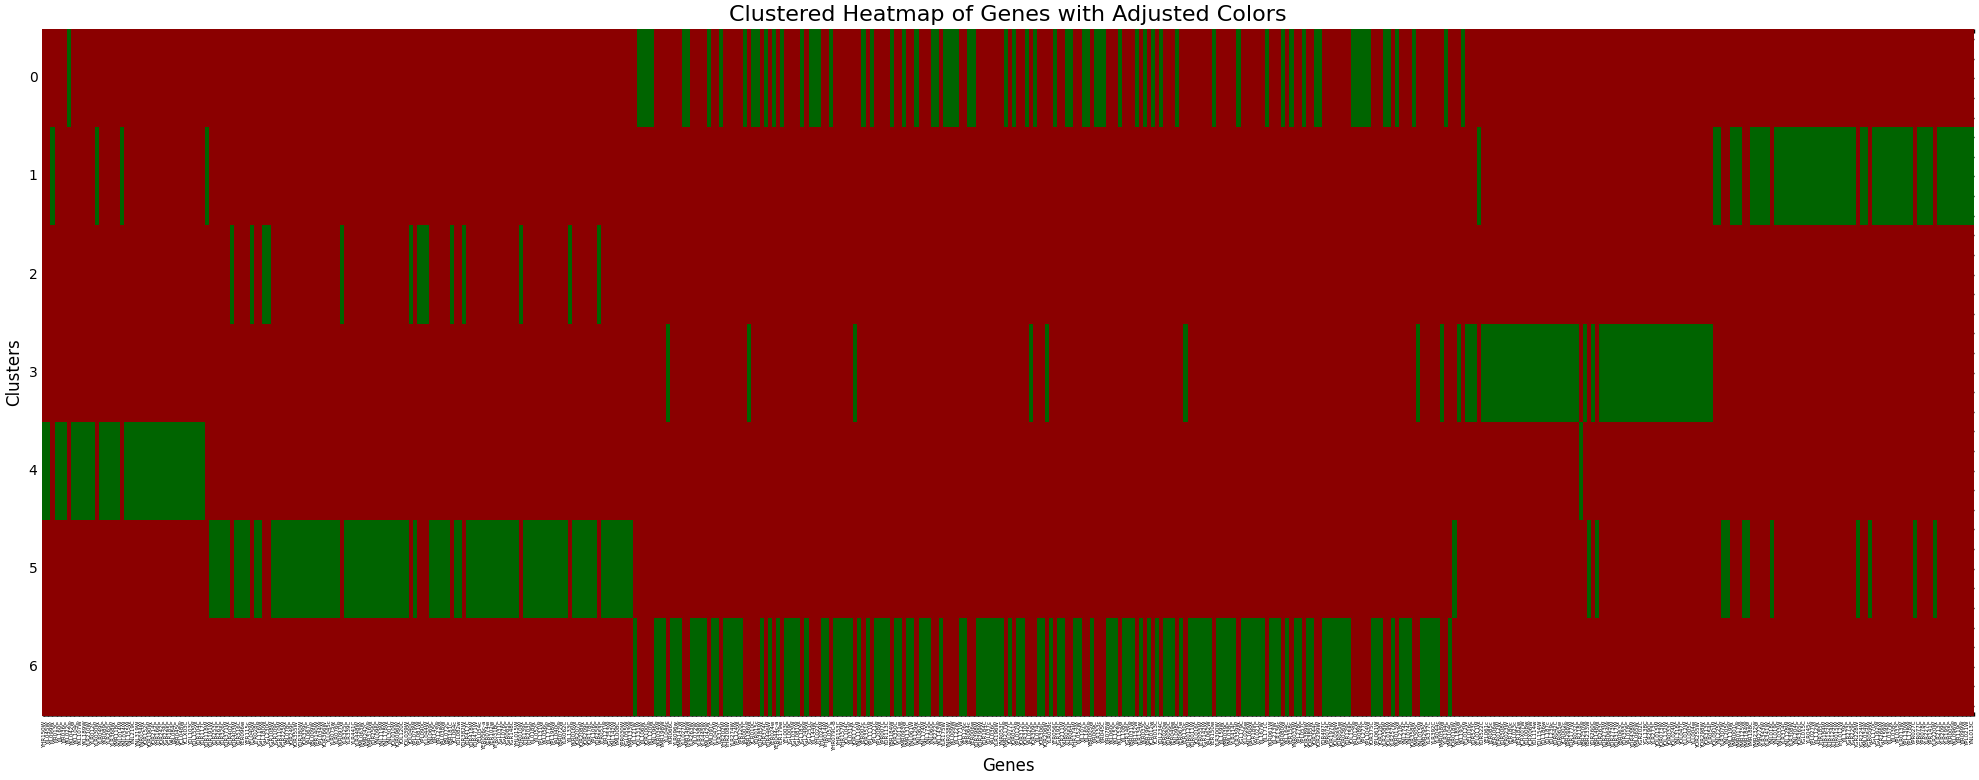

In [54]:
df = data_normalized
data = df.drop('Genes', axis=1).values

# Apply KMeans clustering
K = 7
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Add cluster labels to the DataFrame
df['Cluster'] = labels

# Sort the DataFrame by cluster labels
df_sorted = df.sort_values('Cluster').reset_index(drop=True)
# Create a binary cluster-gene matrix
n_genes = X.shape[0]
cluster_gene_matrix = np.zeros((K, n_genes))

for gene_idx in range(n_genes):
    cluster_idx = labels[gene_idx]
    cluster_gene_matrix[cluster_idx, gene_idx] = 1
sorted_genes = df_sorted['Genes'].values
sorted_indices = df_sorted.index.values
cluster_gene_matrix_sorted = cluster_gene_matrix[:, sorted_indices]

custom_cmap = ListedColormap(['#8B0000', '#006400'])  

plt.figure(figsize=(20, 8))
sns.heatmap(cluster_gene_matrix_sorted, cmap=custom_cmap, cbar=False, xticklabels=sorted_genes, yticklabels=np.arange(K))
plt.xticks(rotation=90, fontsize=4)  
plt.yticks(rotation=0)  
plt.xlabel('Genes')
plt.ylabel('Clusters')
plt.title('Clustered Heatmap of Genes with Adjusted Colors')

plt.tight_layout()
plt.show()
